In [1]:
import scanpy as sc
import pandas as pd
import pickle
import time
import numpy as np
import graph_tool.all as gt
%matplotlib inline
%pylab

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /usr/lib/python3/dist-packages/cairo/_cairo.cpython-37m-x86_64-linux-gnu.so: undefined symbol: cairo_tee_surface_index
  warnings.warn(msg, RuntimeWarning)


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import anndata
adata=sc.read('adata_10x/adata_sc_10x.h5ad')
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
df_significativo= pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20) #### df con i 20 geni significativi per gruppo
cell_annotation= pd.read_table('../sc_mixology/data/csv/sc_10x_5cl.metadata.csv.gz', compression="gzip", sep=",", index_col=0)
adata.obs.loc[:, "cell_line"] = cell_annotation.loc[adata.obs_names, "cell_line"]

In [3]:
g = pickle.load( open( "adata_10x/10x_graph_g.pkl", "rb" ))

In [57]:
a=sc.tl.louvain(adata, resolution=0.05
               )

In [6]:
state= gt.minimize_nested_blockmodel_dl(g,deg_corr=False)
state

NameError: name 'g' is not defined

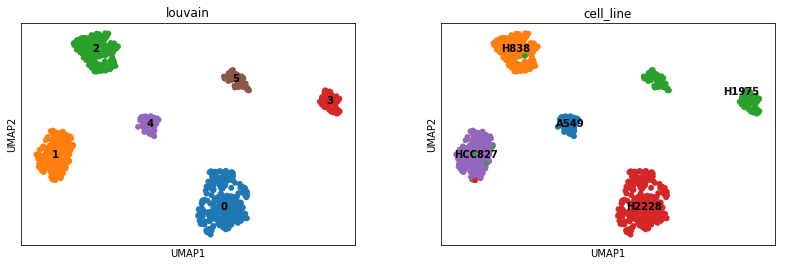

In [58]:
sc.pl.umap(adata, color=["louvain", 'cell_line'], legend_loc='on data')

In [77]:
pickle.dump(state, open('adata_10x/10x_entropy/state_base.pkl','wb'),2)

In [3]:
state=pickle.load(open('adata_10x/10x_entropy/state_base.pkl','rb'))

### multiflip

In [79]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
stateM = state.copy(bs=bs, sampling=True)
stateM.multiflip_mcmc_sweep(niter=10000)
pickle.dump(stateM, open('adata_10x/10x_entropy/state_multiflip.pkl','wb'),2)
stateM

<NestedBlockState object, with base <BlockState object with 76 blocks (67 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f882d27b4d0>, at 0x7f882d960f90>, and 10 levels of sizes [(860, 67), (67, 16), (16, 5), (5, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f882d063d10>

In [3]:
stateM=pickle.load(open('adata_10x/10x_entropy/state_multiflip.pkl','rb'))

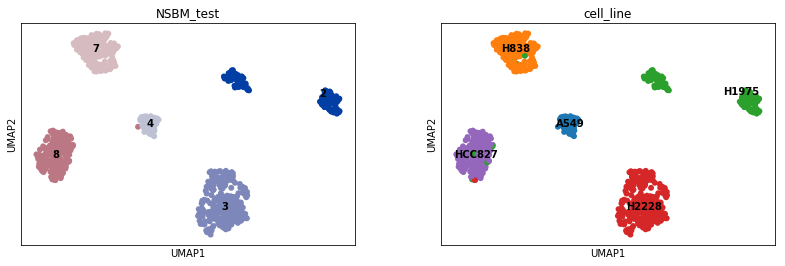

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
2,0,0,127,0,0
3,0,0,0,295,0
4,61,0,0,0,0
7,0,176,7,0,0
8,1,0,4,1,188


In [81]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(stateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [118]:
bs = state.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))
stateM = state.copy(bs=bs, sampling=True)
a=time.time()
stateM.multiflip_mcmc_sweep(niter=50000)
b=time.time()
c=b-a
print(c)
pickle.dump(stateM, open('adata_10x/10x_entropy/state_multiflip2.pkl','wb'),2)
stateM

230.28760385513306


<NestedBlockState object, with base <BlockState object with 77 blocks (68 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f882d27b4d0>, at 0x7f882ca72410>, and 10 levels of sizes [(860, 68), (68, 15), (15, 5), (5, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f882ca723d0>

In [119]:
stateM=pickle.load(open('adata_10x/10x_entropy/state_multiflip2.pkl','rb'))

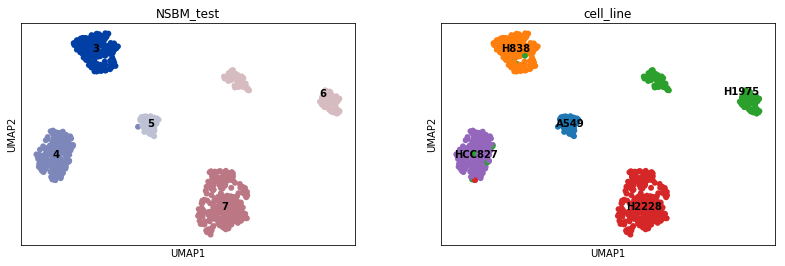

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
3,0,176,7,0,0
4,1,0,4,1,188
5,61,0,0,0,0
6,0,0,127,0,0
7,0,0,0,295,0


In [120]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(stateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

### equilibrate

In [82]:
bs = stateM.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estateM = stateM.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_equilibrate(estateM,wait=1000,nbreaks=2,max_niter=1000000,epsilon=0.001,gibbs=False,multiflip=True,force_niter=None, mcmc_args=dict(niter=10))
b=time.time()
c=b-a
print(c)
pickle.dump(estateM, open('adata_10x/10x_entropy/state_equilibrate.pkl','wb'),2)
estateM

306.0329201221466


<NestedBlockState object, with base <BlockState object with 80 blocks (72 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f882c9afed0>, at 0x7f882ca80950>, and 10 levels of sizes [(860, 72), (72, 17), (17, 7), (7, 3), (3, 3), (3, 2), (2, 1), (1, 1), (1, 1), (1, 1)] at 0x7f882ca806d0>

In [12]:
estateM=pickle.load(open('adata_10x/10x_entropy/state_equilibrate.pkl','rb'))

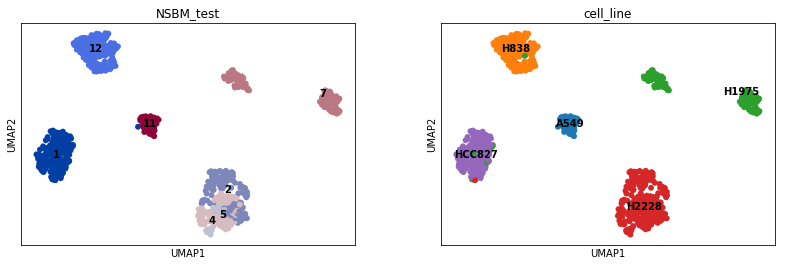

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,1,0,4,1,188
2,0,0,0,147,0
4,0,0,0,22,0
5,0,0,0,126,0
7,0,0,127,0,0
11,61,0,0,0,0
12,0,176,7,0,0


In [84]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateM.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [88]:
bs = stateM.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estateM = stateM.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_equilibrate(estateM,wait=1000,nbreaks=2,max_niter=1000000,epsilon=0.001,gibbs=False,multiflip=True,force_niter=None, mcmc_args=dict(niter=10))
b=time.time()
c=b-a
print(c)
pickle.dump(estateM, open('adata_10x/10x_entropy/state_equilibrate2.pkl','wb'),2)
estateM

179.77402758598328


<NestedBlockState object, with base <BlockState object with 79 blocks (70 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f882c9afed0>, at 0x7f882cc07d50>, and 10 levels of sizes [(860, 70), (70, 15), (15, 5), (5, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f882cc07cd0>

In [11]:
estateM2=pickle.load(open('adata_10x/10x_entropy/state_equilibrate2.pkl','rb'))

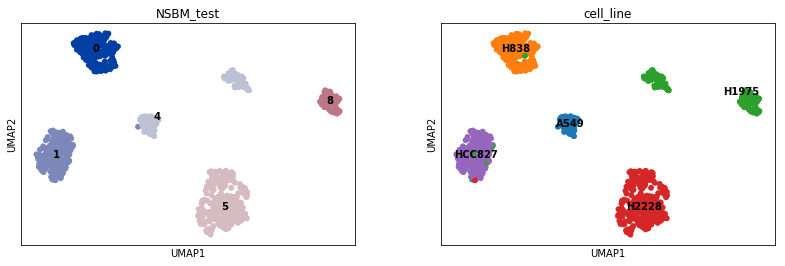

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
0,0,176,7,0,0
1,1,0,4,1,188
4,61,0,56,0,0
5,0,0,0,295,0
8,0,0,71,0,0


In [92]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateM2.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [26]:
bs = stateM.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estateM = stateM.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_equilibrate(estateM,wait=1000,nbreaks=2,max_niter=100000,epsilon=0.001,gibbs=False,multiflip=True,force_niter=None, mcmc_args=dict(niter=10))
b=time.time()
c=b-a
print(c)
pickle.dump(estateM, open('adata_10x/10x_entropy/state_equilibrate3.pkl','wb'),2)
estateM

243.51071906089783


<NestedBlockState object, with base <BlockState object with 79 blocks (69 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7fcce6439250>, at 0x7fcc94783710>, and 10 levels of sizes [(860, 69), (69, 15), (15, 4), (4, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7fcc9454f390>

In [10]:
estateM3=pickle.load(open('adata_10x/10x_entropy/state_equilibrate3.pkl','rb'))

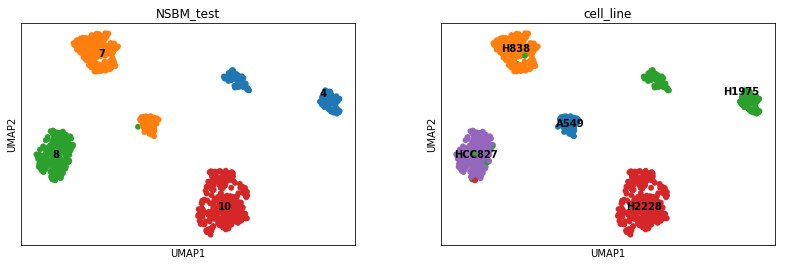

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
4,0,0,127,0,0
7,61,176,7,0,0
8,1,0,4,1,188
10,0,0,0,295,0


In [28]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateM3.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [130]:
bs = stateM.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estateM = stateM.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_equilibrate(estateM,wait=1000,nbreaks=2,max_niter=100000,epsilon=0,gibbs=False,multiflip=False,force_niter=None, mcmc_args=dict(niter=10))
b=time.time()
c=b-a
print(c)
pickle.dump(estateM, open('adata_10x/10x_entropy/state_equilibrate4.pkl','wb'),2)
estateM

81.4163727760315


<NestedBlockState object, with base <BlockState object with 77 blocks (68 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f882c81ccd0>, at 0x7f882c7206d0>, and 10 levels of sizes [(860, 68), (68, 14), (14, 5), (5, 3), (3, 3), (3, 3), (3, 3), (3, 2), (2, 2), (2, 2)] at 0x7f882c720450>

In [8]:
estateM4=pickle.load(open('adata_10x/10x_entropy/state_equilibrate4.pkl','rb'))

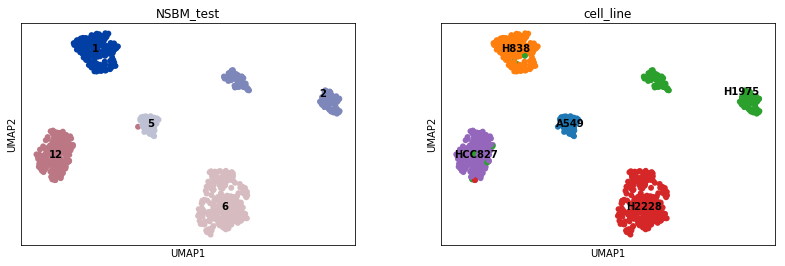

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,0,176,7,0,0
2,0,0,127,0,0
5,61,0,0,0,0
6,0,0,0,295,0
12,1,0,4,1,188


In [132]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateM4.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

In [134]:
bs = stateM.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

estateM = stateM.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_equilibrate(estateM,wait=1000,nbreaks=2,max_niter=100000,epsilon=0,gibbs=False,multiflip=False,force_niter=None, mcmc_args=dict(niter=10))
b=time.time()
c=b-a
print(c)
pickle.dump(estateM, open('adata_10x/10x_entropy/state_equilibrate5.pkl','wb'),2)
estateM

109.99665260314941


<NestedBlockState object, with base <BlockState object with 77 blocks (68 nonempty), for graph <Graph object, undirected, with 860 vertices and 5976 edges at 0x7f882c81ccd0>, at 0x7f882c6cc210>, and 10 levels of sizes [(860, 68), (68, 18), (18, 8), (8, 4), (4, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 2)] at 0x7f882c6cc190>

In [4]:
estateM5=pickle.load(open('adata_10x/10x_entropy/state_equilibrate5.pkl','rb'))

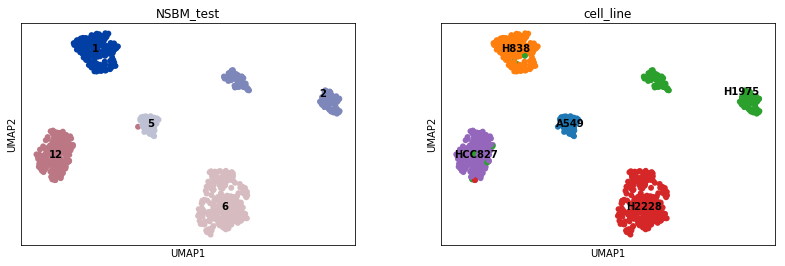

cell_line,A549,H838,H1975,H2228,HCC827
NSBM_test,,,,,
1,0,176,7,0,0
2,0,0,127,0,0
5,61,0,0,0,0
6,0,0,0,295,0
12,1,0,4,1,188


In [136]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estateM4.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'cell_line'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.cell_line)

# 1) level_entropy
### 1a) state

In [85]:
state_entropy=[]
for i in range(5):
    entropy=state.level_entropy(i)
    state_entropy.append(entropy)
print(state_entropy)

[17671.561343174253, 1567.7873131574997, 200.3105886304923, 61.42020370792713, 17.39151539166778]


In [86]:
stateM_entropy=[]
for i in range(10):
    entropy=stateM.level_entropy(i)
    stateM_entropy.append(entropy)
print(stateM_entropy)

[17640.7722183204, 1564.8898499796037, 248.68831788875087, 62.632058402815694, 17.39151539166778, 0.0, 0.0, 0.0, 0.0, 0.0]


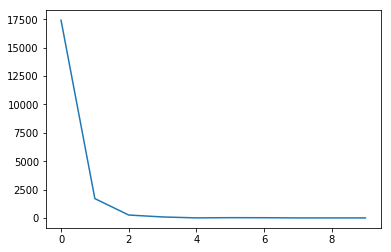

In [15]:
estateM_entropy=[]
for i in range(10):
    entropy=estateM.level_entropy(i)
    estateM_entropy.append(entropy)
plot(estateM_entropy)

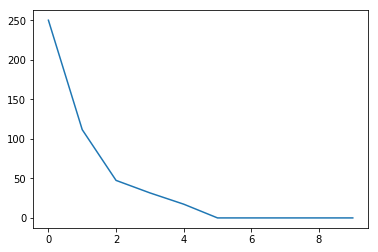

In [20]:
estateM2_entropy=[]
for i in range(10):
    entropy=estateM2.level_entropy(i)
    estateM2_entropy.append(entropy)
nb = np.array([x.get_nonempty_B() for x in estateM2.get_levels()])
plot(estateM2_entropy/nb)

In [22]:
estateM2.entropy()

19502.869365459643

In [24]:
estateM4.entropy()

19560.526059181688

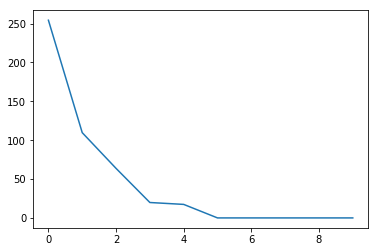

In [21]:
estateM3_entropy=[]
for i in range(10):
    entropy=estateM3.level_entropy(i)
    estateM3_entropy.append(entropy)
nb = np.array([x.get_nonempty_B() for x in estateM3.get_levels()])
plot(estateM3_entropy/nb)

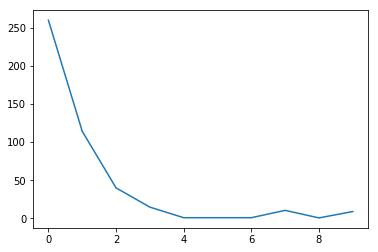

In [19]:
estateM4_entropy=[]
for i in range(10):
    entropy=estateM4.level_entropy(i)
    estateM4_entropy.append(entropy)
nb = np.array([x.get_nonempty_B() for x in estateM4.get_levels()])
plot(estateM4_entropy/nb)


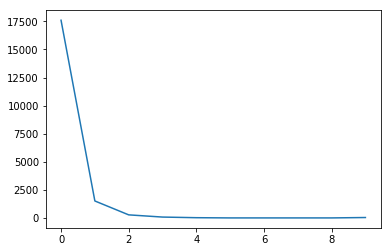

In [7]:
estateM5_entropy=[]
for i in range(10):
    entropy=estateM5.level_entropy(i)
    estateM5_entropy.append(entropy)
plot(estateM5_entropy)
#yscale('log')